### DCGAN cu optimizari

image_size = 32
channels = 1

In [17]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

In [18]:
ngpu = 0
dataroot = "Data/SpectrogramsB"
filename_gen = "DCGAN/DCGAN-Gen.joblib"
filename_dis = "DCGAN/DCGAN-Dis.joblib"
workers = 2
batch_size = 32

image_size = 32

# channels nr for input images
nc = 1

# size of feature maps in generator
ngf = 64

# size of feature maps in discriminator
ndf = 64

num_epochs = 20
lr = 0.0002
lrD = 0.000001
beta1 = 0.5

def find_classes(directory:str):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_index = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_index

In [19]:
class MyImageFolder(torch.utils.data.Dataset):
    def __init__(self, directory:str, transform=None):

        self.paths = list(pathlib.Path(directory).glob('*/*.jpg'))

        self.transform = transform
        self.classes, self.class_to_index = find_classes(directory)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_index = self.class_to_index[class_name]

        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

transform = torchvision.transforms.Compose([
            #torchvision.transforms.RandomResizedCrop(image_size),
            #torchvision.transforms.Resize(64),
            #torchvision.transforms.RandomCrop(64),
            # TODO test this
            #torchvision.transforms.RandomResizedCrop(image_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            # torchvision.transforms.RandomHorizontalFlip(p=0.3)

            torchvision.transforms.ToTensor(),  # imaginile sunt normalizate intre [0, 1]
            torchvision.transforms.Normalize(0.5, 0.5),  # imaginile sunt normalizate intre [-1, 1]
        ])


In [20]:
train_data = MyImageFolder(directory="Data/SpectrogramsB", transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [21]:
'''
Gaussian distribution (also known as normal distribution) is a bell-shaped curve, and it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.
'''
class GaussianNoise(torch.nn.Module):
    def __init__(self, std=0.1, decay=0):
        super().__init__()
        self.std = std
        self.decay = decay

    def step(self):
        self.std = max(self.std - self.decay, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [22]:
'''
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [23]:
# TODO train cu si fara GaussianNoise()

# maybe ReLU in generator
generator = torch.nn.Sequential(
    # 1 x 32 x 32

    # downsampling
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 31 x 31
    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 30 x 30

    # TODO asta in loc de stratul de mai sus
    # torch.nn.AvgPool2d(kernel_size=4, stride=2, padding=1)
    # ngf x 32 x 32

    torch.nn.Conv2d(ngf * 2, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 4),
    torch.nn.LeakyReLU(True),
    # ngf*4 x 15 x 15

    torch.nn.Conv2d(ngf * 4, ngf * 8, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 8),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 14 x 14

    # upsampling
    torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 4),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 15 x 15

    torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf x 30 x 30

    torch.nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 31 x 31

    # TODO asta in loc de stratul de mai sus
    # torch.nn.PixelShuffle(upscale_factor=2),
    # ngf/2 x 64 x 64


    torch.nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=1, padding=1, bias=False),
    torch.nn.Tanh(),
    # ngf x 32 x 32

)

generator.apply(weights_init)




Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=True)
  (12): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (13): BatchNorm2d(256, eps=1e-05, moment

In [24]:
# Discriminator model
# TODO train cu si fara GaussianNoise()
# TODO de incercat torch.nn.AvgPool2d(kernel_size=4, stride=2, padding=1) in loc de batchnorm
# TODO incercat cu torch.nn.Dropout(p=0.3) in loc de BatchNorm2d
discriminator = torch.nn.Sequential(
    # nc x 32 x 32
    GaussianNoise(),
    torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf x 16 x 16
    GaussianNoise(),
    torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
    torch.nn.BatchNorm2d(ndf * 2),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # nfd*2 x 8 x 8
    GaussianNoise(),
    torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    torch.nn.BatchNorm2d(ndf * 4),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf*4 x 4 x 4
    # GaussianNoise(),
    # torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
    # torch.nn.BatchNorm2d(ndf * 8),
    # torch.nn.LeakyReLU(0.2, inplace=True),
    # # nfd*8 x 8 x 8
    # GaussianNoise(),
    # torch.nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
    # torch.nn.BatchNorm2d(ndf * 8),
    # torch.nn.LeakyReLU(0.2, inplace=True),
    # # nfd*8 x 4 x 4
    GaussianNoise(),
    torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
    torch.nn.Sigmoid(),
)
discriminator.apply(weights_init)



Sequential(
  (0): GaussianNoise()
  (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): GaussianNoise()
  (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): GaussianNoise()
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): GaussianNoise()
  (12): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Sigmoid()
)

In [25]:
criterion = torch.nn.BCELoss()
fixed_noise = torch.randn(batch_size, nc, image_size, image_size, device=device)
real_label = 1
fake_label = 0

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999))
scheduler_gen = ReduceLROnPlateau(gen_optimizer, patience=1, factor=0.1, min_lr=0.00000001, verbose=True)
# scheduler_dis = ReduceLROnPlateau(dis_optimizer, patience=2, factor=0.2, min_lr=0.0000001)

In [26]:
def normalize(x, minim, maxim):
    return (x - minim) / (maxim - minim)

def smooth_label(label):
    arr = torch.rand((b_size,), dtype=torch.float, device=device)
    if label == 1:
        for i in range(arr.shape[0]):
            arr[i] = normalize(arr[i], 0.7, 1.2)
    else:
        for i in range(arr.shape[0]):
            arr[i] = normalize(arr[i], 0.0, 0.3)
    return arr

img_lists = []
gen_losses = []
dis_losses = []
iters = 0


In [27]:
for epoch in range(num_epochs):
    err_dis = 0
    err_gen = 0
    for i, data in tqdm(enumerate(dataloader)):
        # initializez gradientii cu 0
        discriminator.zero_grad()
        real = data[0].to(device)
        # data[0] sunt imaginile
        # data[1] sunt labelurile

        b_size = real.size(0)  # batch size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # TODO test this
        # label = smooth_label(real_label)

        # print(real_cpu.shape)
        # noise_dis = torch.randn(b_size, nc, image_size, image_size, device=device)
        # real = real + noise_dis
        output = discriminator(real).view(-1)
        # print(output.shape)
        err_dis_real = criterion(output, label)

        # "backward pass" refers to process of counting changes in weights
        err_dis_real.backward()

        dis_x = output.mean().item()
        #
        noise = torch.randn(b_size, nc, image_size, image_size, device=device)

        fake = generator(noise)
        # fake = fake + noise_dis
        label.fill_(fake_label)
        #label = smooth_label(fake_label)


        output = discriminator(fake.detach()).view(-1)
        # print("Discriminated fake")
        err_dis_fake = criterion(output, label)
        err_dis_fake.backward()
        dis_gen_z1 = output.mean().item()
        err_dis = err_dis_real + err_dis_fake
        # Update D
        dis_optimizer.step()


        generator.zero_grad()
        label.fill_(real_label)
        #label = smooth_label(real_label)
        output = discriminator(fake).view(-1)
        # print("Discriminated fake2")
        err_gen = criterion(output, label)
        err_gen.backward()
        dis_gen_z2 = output.mean().item()
        gen_optimizer.step()

        if i % 100 == 0 and i != 0:
            print(f"[{epoch}/{num_epochs - 1}] [{i}/{len(dataloader) - 1}]\tLoss_dis: {err_dis.item():.4f}\tLoss_gen: {err_gen.item():.4f}\tD(x): {dis_x:.4f}\tD(G(x)): {dis_gen_z1:.4f} / {dis_gen_z2:.4f}")

        gen_losses.append(err_gen.item())
        dis_losses.append(err_dis.item())

        # if iters % 500 == 0 or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        img_lists.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    scheduler_gen.step(err_gen.item())

    # scheduler_dis.step(errD.item())


    joblib.dump(generator, filename_gen)
    joblib.dump(generator, filename_dis)

    gen_losses_arr = np.array(gen_losses, dtype=object)
    dis_losses_arr = np.array(dis_losses, dtype=object)
    np.save('DCGAN/DCGAN-gen_losses.npy', gen_losses_arr)
    np.save('DCGAN/DCGAN-dis_losses.npy', dis_losses_arr)

# for i, ms in enumerate(img_lists):
#     ms = ms.numpy()
#     im = Image.fromarray(ms)
#     if im.mode != 'L':
#         im = im.convert('L')
#     im.save(f"Data/generated/gen_spec{i}.jpg")


100it [02:25,  1.44s/it]

[0/19] [100/512]	Loss_dis: 1.5155	Loss_gen: 0.7911	D(x): 0.5279	D(G(x)): 0.5136 / 0.4899


200it [05:17,  1.68s/it]

[0/19] [200/512]	Loss_dis: 1.4076	Loss_gen: 0.9220	D(x): 0.5107	D(G(x)): 0.4357 / 0.4550


300it [08:02,  1.59s/it]

[0/19] [300/512]	Loss_dis: 1.6511	Loss_gen: 0.6445	D(x): 0.4856	D(G(x)): 0.5372 / 0.5511


400it [10:46,  1.65s/it]

[0/19] [400/512]	Loss_dis: 1.6281	Loss_gen: 0.5713	D(x): 0.5514	D(G(x)): 0.5838 / 0.5976


500it [13:36,  1.55s/it]

[0/19] [500/512]	Loss_dis: 1.6098	Loss_gen: 0.5632	D(x): 0.5373	D(G(x)): 0.5576 / 0.6007


513it [13:58,  1.64s/it]
100it [02:45,  1.50s/it]

[1/19] [100/512]	Loss_dis: 2.0789	Loss_gen: 0.3136	D(x): 0.4604	D(G(x)): 0.6736 / 0.7409


200it [05:36,  1.86s/it]

[1/19] [200/512]	Loss_dis: 2.2549	Loss_gen: 0.3847	D(x): 0.4350	D(G(x)): 0.7072 / 0.6937


300it [08:23,  1.68s/it]

[1/19] [300/512]	Loss_dis: 2.1688	Loss_gen: 0.2857	D(x): 0.4551	D(G(x)): 0.7036 / 0.7604


400it [11:14,  2.26s/it]

[1/19] [400/512]	Loss_dis: 2.2978	Loss_gen: 0.4131	D(x): 0.3995	D(G(x)): 0.6787 / 0.6807


500it [13:54,  1.58s/it]

[1/19] [500/512]	Loss_dis: 2.0093	Loss_gen: 0.4373	D(x): 0.4453	D(G(x)): 0.6507 / 0.6666


513it [14:14,  1.66s/it]
100it [02:39,  1.57s/it]

[2/19] [100/512]	Loss_dis: 1.9867	Loss_gen: 0.6052	D(x): 0.4976	D(G(x)): 0.6712 / 0.5638


200it [05:13,  1.57s/it]

[2/19] [200/512]	Loss_dis: 2.1104	Loss_gen: 0.4322	D(x): 0.4675	D(G(x)): 0.6790 / 0.6628


300it [07:51,  1.55s/it]

[2/19] [300/512]	Loss_dis: 2.1304	Loss_gen: 0.4392	D(x): 0.4071	D(G(x)): 0.6674 / 0.6604


400it [10:24,  1.55s/it]

[2/19] [400/512]	Loss_dis: 1.7238	Loss_gen: 0.5291	D(x): 0.4512	D(G(x)): 0.5464 / 0.6123


500it [12:59,  1.55s/it]

[2/19] [500/512]	Loss_dis: 1.8453	Loss_gen: 0.5877	D(x): 0.4914	D(G(x)): 0.6077 / 0.5805


513it [13:19,  1.56s/it]

Epoch 00003: reducing learning rate of group 0 to 2.0000e-05.



100it [02:33,  1.45s/it]

[3/19] [100/512]	Loss_dis: 1.2909	Loss_gen: 0.9196	D(x): 0.5186	D(G(x)): 0.4101 / 0.4353


200it [05:06,  1.44s/it]

[3/19] [200/512]	Loss_dis: 1.3438	Loss_gen: 1.0591	D(x): 0.5057	D(G(x)): 0.4151 / 0.3751


300it [07:44,  1.69s/it]

[3/19] [300/512]	Loss_dis: 1.4239	Loss_gen: 0.8574	D(x): 0.5180	D(G(x)): 0.4625 / 0.4611


400it [10:21,  1.65s/it]

[3/19] [400/512]	Loss_dis: 1.3142	Loss_gen: 1.0563	D(x): 0.4975	D(G(x)): 0.3983 / 0.3857


500it [12:58,  1.58s/it]

[3/19] [500/512]	Loss_dis: 1.1144	Loss_gen: 1.0128	D(x): 0.6146	D(G(x)): 0.4248 / 0.3986


513it [13:18,  1.56s/it]
100it [02:34,  1.55s/it]

[4/19] [100/512]	Loss_dis: 1.0476	Loss_gen: 1.0084	D(x): 0.6213	D(G(x)): 0.3880 / 0.3956


200it [05:12,  1.77s/it]

[4/19] [200/512]	Loss_dis: 1.1792	Loss_gen: 0.9929	D(x): 0.5762	D(G(x)): 0.4200 / 0.4044


300it [07:46,  1.56s/it]

[4/19] [300/512]	Loss_dis: 1.0285	Loss_gen: 1.1894	D(x): 0.5740	D(G(x)): 0.3259 / 0.3444


400it [10:23,  1.55s/it]

[4/19] [400/512]	Loss_dis: 1.0495	Loss_gen: 1.1625	D(x): 0.5996	D(G(x)): 0.3438 / 0.3574


500it [13:01,  1.55s/it]

[4/19] [500/512]	Loss_dis: 1.0372	Loss_gen: 1.0822	D(x): 0.6401	D(G(x)): 0.4059 / 0.3914


513it [13:21,  1.56s/it]

Epoch 00005: reducing learning rate of group 0 to 2.0000e-06.



100it [02:34,  1.44s/it]

[5/19] [100/512]	Loss_dis: 0.8582	Loss_gen: 1.5267	D(x): 0.6482	D(G(x)): 0.3028 / 0.2583


200it [05:09,  1.55s/it]

[5/19] [200/512]	Loss_dis: 0.7345	Loss_gen: 1.5469	D(x): 0.7104	D(G(x)): 0.2875 / 0.2575


300it [07:42,  1.56s/it]

[5/19] [300/512]	Loss_dis: 0.7641	Loss_gen: 1.5449	D(x): 0.6492	D(G(x)): 0.2437 / 0.2528


400it [10:18,  1.54s/it]

[5/19] [400/512]	Loss_dis: 0.6416	Loss_gen: 1.5434	D(x): 0.7016	D(G(x)): 0.2278 / 0.2433


500it [12:56,  1.57s/it]

[5/19] [500/512]	Loss_dis: 0.7494	Loss_gen: 1.1763	D(x): 0.7138	D(G(x)): 0.3007 / 0.3355


513it [13:15,  1.55s/it]
100it [02:34,  1.55s/it]

[6/19] [100/512]	Loss_dis: 0.6971	Loss_gen: 1.4764	D(x): 0.7146	D(G(x)): 0.2801 / 0.2857


200it [05:06,  1.60s/it]

[6/19] [200/512]	Loss_dis: 0.6726	Loss_gen: 1.5605	D(x): 0.7151	D(G(x)): 0.2523 / 0.2342


300it [07:35,  1.52s/it]

[6/19] [300/512]	Loss_dis: 0.6184	Loss_gen: 1.6268	D(x): 0.7425	D(G(x)): 0.2539 / 0.2270


400it [10:03,  1.47s/it]

[6/19] [400/512]	Loss_dis: 0.5274	Loss_gen: 1.5595	D(x): 0.7813	D(G(x)): 0.2200 / 0.2398


500it [12:32,  1.46s/it]

[6/19] [500/512]	Loss_dis: 0.5885	Loss_gen: 1.6843	D(x): 0.7493	D(G(x)): 0.2167 / 0.2207


513it [12:51,  1.50s/it]

Epoch 00007: reducing learning rate of group 0 to 2.0000e-07.



100it [02:28,  1.45s/it]

[7/19] [100/512]	Loss_dis: 0.5204	Loss_gen: 1.8732	D(x): 0.7717	D(G(x)): 0.2069 / 0.1808


200it [04:57,  1.46s/it]

[7/19] [200/512]	Loss_dis: 0.4684	Loss_gen: 1.9544	D(x): 0.7751	D(G(x)): 0.1739 / 0.1734


300it [07:25,  1.36s/it]

[7/19] [300/512]	Loss_dis: 0.4236	Loss_gen: 2.2441	D(x): 0.7819	D(G(x)): 0.1446 / 0.1227


400it [09:54,  1.47s/it]

[7/19] [400/512]	Loss_dis: 0.3514	Loss_gen: 2.0474	D(x): 0.8272	D(G(x)): 0.1372 / 0.1484


500it [12:22,  1.48s/it]

[7/19] [500/512]	Loss_dis: 0.3261	Loss_gen: 2.5153	D(x): 0.8536	D(G(x)): 0.1437 / 0.0963


513it [12:41,  1.48s/it]
100it [02:29,  1.48s/it]

[8/19] [100/512]	Loss_dis: 0.2301	Loss_gen: 2.4272	D(x): 0.8837	D(G(x)): 0.0951 / 0.1011


200it [04:58,  1.46s/it]

[8/19] [200/512]	Loss_dis: 0.3126	Loss_gen: 2.3867	D(x): 0.8549	D(G(x)): 0.1220 / 0.1097


300it [07:28,  1.49s/it]

[8/19] [300/512]	Loss_dis: 0.2481	Loss_gen: 2.6636	D(x): 0.8811	D(G(x)): 0.1070 / 0.0932


400it [09:56,  1.46s/it]

[8/19] [400/512]	Loss_dis: 0.2464	Loss_gen: 2.6878	D(x): 0.8740	D(G(x)): 0.0959 / 0.0938


500it [12:27,  1.47s/it]

[8/19] [500/512]	Loss_dis: 0.2419	Loss_gen: 2.5990	D(x): 0.8901	D(G(x)): 0.1103 / 0.0879


513it [12:46,  1.49s/it]

Epoch 00009: reducing learning rate of group 0 to 2.0000e-08.



100it [02:27,  1.46s/it]

[9/19] [100/512]	Loss_dis: 0.2014	Loss_gen: 2.7517	D(x): 0.8985	D(G(x)): 0.0841 / 0.0862


200it [04:57,  1.49s/it]

[9/19] [200/512]	Loss_dis: 0.1469	Loss_gen: 2.9082	D(x): 0.9266	D(G(x)): 0.0657 / 0.0796


300it [07:27,  1.46s/it]

[9/19] [300/512]	Loss_dis: 0.1774	Loss_gen: 2.9310	D(x): 0.9106	D(G(x)): 0.0765 / 0.0752


400it [09:56,  1.59s/it]

[9/19] [400/512]	Loss_dis: 0.1683	Loss_gen: 3.0394	D(x): 0.9176	D(G(x)): 0.0742 / 0.0701


500it [12:26,  1.46s/it]

[9/19] [500/512]	Loss_dis: 0.1577	Loss_gen: 3.0413	D(x): 0.9066	D(G(x)): 0.0523 / 0.0586


513it [12:45,  1.49s/it]
100it [02:30,  1.50s/it]

[10/19] [100/512]	Loss_dis: 0.1014	Loss_gen: 3.0632	D(x): 0.9472	D(G(x)): 0.0451 / 0.0667


200it [05:00,  1.50s/it]

[10/19] [200/512]	Loss_dis: 0.0945	Loss_gen: 3.0023	D(x): 0.9446	D(G(x)): 0.0344 / 0.0692


300it [07:30,  1.50s/it]

[10/19] [300/512]	Loss_dis: 0.1362	Loss_gen: 3.4983	D(x): 0.9279	D(G(x)): 0.0545 / 0.0378


400it [09:55,  1.44s/it]

[10/19] [400/512]	Loss_dis: 0.0951	Loss_gen: 3.4984	D(x): 0.9491	D(G(x)): 0.0401 / 0.0453


500it [12:19,  1.40s/it]

[10/19] [500/512]	Loss_dis: 0.1031	Loss_gen: 3.6507	D(x): 0.9367	D(G(x)): 0.0352 / 0.0329


513it [12:38,  1.48s/it]

Epoch 00011: reducing learning rate of group 0 to 1.0000e-08.



100it [02:24,  1.39s/it]

[11/19] [100/512]	Loss_dis: 0.0904	Loss_gen: 3.5280	D(x): 0.9457	D(G(x)): 0.0322 / 0.0350


200it [04:50,  1.47s/it]

[11/19] [200/512]	Loss_dis: 0.0680	Loss_gen: 3.6622	D(x): 0.9658	D(G(x)): 0.0319 / 0.0336


300it [07:14,  1.41s/it]

[11/19] [300/512]	Loss_dis: 0.0753	Loss_gen: 3.9079	D(x): 0.9593	D(G(x)): 0.0322 / 0.0283


400it [09:40,  1.43s/it]

[11/19] [400/512]	Loss_dis: 0.0679	Loss_gen: 4.1319	D(x): 0.9678	D(G(x)): 0.0337 / 0.0210


500it [12:03,  1.41s/it]

[11/19] [500/512]	Loss_dis: 0.0539	Loss_gen: 4.2180	D(x): 0.9709	D(G(x)): 0.0237 / 0.0202


513it [12:22,  1.45s/it]
100it [02:25,  1.57s/it]

[12/19] [100/512]	Loss_dis: 0.0564	Loss_gen: 3.9553	D(x): 0.9719	D(G(x)): 0.0270 / 0.0286


200it [04:50,  1.51s/it]

[12/19] [200/512]	Loss_dis: 0.0527	Loss_gen: 4.3413	D(x): 0.9683	D(G(x)): 0.0199 / 0.0166


300it [07:16,  1.44s/it]

[12/19] [300/512]	Loss_dis: 0.0542	Loss_gen: 4.3080	D(x): 0.9713	D(G(x)): 0.0238 / 0.0199


400it [09:40,  1.49s/it]

[12/19] [400/512]	Loss_dis: 0.0398	Loss_gen: 4.2293	D(x): 0.9772	D(G(x)): 0.0163 / 0.0234


500it [12:07,  1.48s/it]

[12/19] [500/512]	Loss_dis: 0.0395	Loss_gen: 4.4471	D(x): 0.9782	D(G(x)): 0.0171 / 0.0163


513it [12:26,  1.45s/it]
100it [02:26,  1.47s/it]

[13/19] [100/512]	Loss_dis: 0.0458	Loss_gen: 4.4014	D(x): 0.9725	D(G(x)): 0.0172 / 0.0145


200it [04:49,  1.41s/it]

[13/19] [200/512]	Loss_dis: 0.0292	Loss_gen: 4.5049	D(x): 0.9833	D(G(x)): 0.0121 / 0.0144


300it [07:14,  1.47s/it]

[13/19] [300/512]	Loss_dis: 0.0346	Loss_gen: 4.7318	D(x): 0.9790	D(G(x)): 0.0129 / 0.0137


400it [09:40,  1.46s/it]

[13/19] [400/512]	Loss_dis: 0.0350	Loss_gen: 4.7946	D(x): 0.9762	D(G(x)): 0.0104 / 0.0123


500it [12:05,  1.50s/it]

[13/19] [500/512]	Loss_dis: 0.0335	Loss_gen: 4.8821	D(x): 0.9759	D(G(x)): 0.0084 / 0.0106


513it [12:25,  1.45s/it]
100it [02:28,  1.60s/it]

[14/19] [100/512]	Loss_dis: 0.0237	Loss_gen: 4.8536	D(x): 0.9882	D(G(x)): 0.0117 / 0.0101


200it [04:54,  1.44s/it]

[14/19] [200/512]	Loss_dis: 0.0191	Loss_gen: 4.7153	D(x): 0.9897	D(G(x)): 0.0087 / 0.0141


300it [07:21,  1.45s/it]

[14/19] [300/512]	Loss_dis: 0.0278	Loss_gen: 5.1844	D(x): 0.9822	D(G(x)): 0.0096 / 0.0093


400it [09:46,  1.39s/it]

[14/19] [400/512]	Loss_dis: 0.0226	Loss_gen: 5.0258	D(x): 0.9872	D(G(x)): 0.0095 / 0.0094


500it [12:14,  1.50s/it]

[14/19] [500/512]	Loss_dis: 0.0181	Loss_gen: 5.2788	D(x): 0.9911	D(G(x)): 0.0091 / 0.0069


513it [12:32,  1.47s/it]
100it [02:25,  1.42s/it]

[15/19] [100/512]	Loss_dis: 0.0232	Loss_gen: 5.4174	D(x): 0.9850	D(G(x)): 0.0077 / 0.0085


200it [04:51,  1.44s/it]

[15/19] [200/512]	Loss_dis: 0.0145	Loss_gen: 5.4717	D(x): 0.9934	D(G(x)): 0.0078 / 0.0062


300it [07:17,  1.48s/it]

[15/19] [300/512]	Loss_dis: 0.0138	Loss_gen: 5.6934	D(x): 0.9932	D(G(x)): 0.0069 / 0.0049


400it [09:47,  1.69s/it]

[15/19] [400/512]	Loss_dis: 0.0171	Loss_gen: 5.4814	D(x): 0.9909	D(G(x)): 0.0078 / 0.0064


500it [12:14,  1.49s/it]

[15/19] [500/512]	Loss_dis: 0.0141	Loss_gen: 5.5169	D(x): 0.9920	D(G(x)): 0.0059 / 0.0052


513it [12:33,  1.47s/it]
100it [02:30,  1.41s/it]

[16/19] [100/512]	Loss_dis: 0.0164	Loss_gen: 5.6330	D(x): 0.9916	D(G(x)): 0.0078 / 0.0058


200it [04:58,  1.51s/it]

[16/19] [200/512]	Loss_dis: 0.0207	Loss_gen: 5.7472	D(x): 0.9847	D(G(x)): 0.0046 / 0.0053


300it [07:25,  1.41s/it]

[16/19] [300/512]	Loss_dis: 0.0119	Loss_gen: 5.6265	D(x): 0.9946	D(G(x)): 0.0064 / 0.0061


400it [09:55,  1.54s/it]

[16/19] [400/512]	Loss_dis: 0.0100	Loss_gen: 5.6943	D(x): 0.9946	D(G(x)): 0.0045 / 0.0051


500it [12:25,  1.65s/it]

[16/19] [500/512]	Loss_dis: 0.0123	Loss_gen: 5.4958	D(x): 0.9937	D(G(x)): 0.0059 / 0.0054


513it [12:43,  1.49s/it]
100it [02:27,  1.56s/it]

[17/19] [100/512]	Loss_dis: 0.0095	Loss_gen: 5.8346	D(x): 0.9937	D(G(x)): 0.0032 / 0.0039


200it [04:56,  1.56s/it]

[17/19] [200/512]	Loss_dis: 0.0093	Loss_gen: 5.8379	D(x): 0.9953	D(G(x)): 0.0046 / 0.0041


300it [07:25,  1.61s/it]

[17/19] [300/512]	Loss_dis: 0.0076	Loss_gen: 6.1454	D(x): 0.9956	D(G(x)): 0.0031 / 0.0029


400it [09:55,  1.41s/it]

[17/19] [400/512]	Loss_dis: 0.0073	Loss_gen: 6.1984	D(x): 0.9960	D(G(x)): 0.0032 / 0.0032


500it [12:23,  1.39s/it]

[17/19] [500/512]	Loss_dis: 0.0061	Loss_gen: 6.0487	D(x): 0.9968	D(G(x)): 0.0029 / 0.0035


513it [12:42,  1.49s/it]
100it [02:29,  1.43s/it]

[18/19] [100/512]	Loss_dis: 0.0060	Loss_gen: 6.2053	D(x): 0.9972	D(G(x)): 0.0032 / 0.0032


200it [04:58,  1.39s/it]

[18/19] [200/512]	Loss_dis: 0.0063	Loss_gen: 6.5588	D(x): 0.9958	D(G(x)): 0.0020 / 0.0018


300it [07:35,  1.52s/it]

[18/19] [300/512]	Loss_dis: 0.0050	Loss_gen: 6.3290	D(x): 0.9976	D(G(x)): 0.0025 / 0.0025


400it [10:04,  1.61s/it]

[18/19] [400/512]	Loss_dis: 0.0059	Loss_gen: 6.4275	D(x): 0.9972	D(G(x)): 0.0031 / 0.0027


500it [12:33,  1.55s/it]

[18/19] [500/512]	Loss_dis: 0.0058	Loss_gen: 6.2088	D(x): 0.9967	D(G(x)): 0.0026 / 0.0025


513it [12:52,  1.51s/it]
100it [02:29,  1.41s/it]

[19/19] [100/512]	Loss_dis: 0.0059	Loss_gen: 6.4272	D(x): 0.9962	D(G(x)): 0.0022 / 0.0027


200it [04:58,  1.41s/it]

[19/19] [200/512]	Loss_dis: 0.0049	Loss_gen: 6.7252	D(x): 0.9969	D(G(x)): 0.0018 / 0.0017


300it [07:29,  1.43s/it]

[19/19] [300/512]	Loss_dis: 0.0047	Loss_gen: 6.5093	D(x): 0.9977	D(G(x)): 0.0025 / 0.0022


400it [09:59,  1.46s/it]

[19/19] [400/512]	Loss_dis: 0.0039	Loss_gen: 6.7180	D(x): 0.9980	D(G(x)): 0.0019 / 0.0018


500it [12:29,  1.47s/it]

[19/19] [500/512]	Loss_dis: 0.0046	Loss_gen: 6.8037	D(x): 0.9972	D(G(x)): 0.0018 / 0.0019


513it [12:48,  1.50s/it]


In [28]:
# generator = joblib.load(filename_gen)
# discriminator = joblib.load(filename_dis)

# for i, ms in enumerate(img_lists):
#     print(ms.shape)
#     ms = ms.numpy()
#     im = Image.fromarray(ms)
#     if im.mode != 'L':
#         im = im.convert('L')
#     im.save(f"Data/generated/gen_spec{i}.jpg")


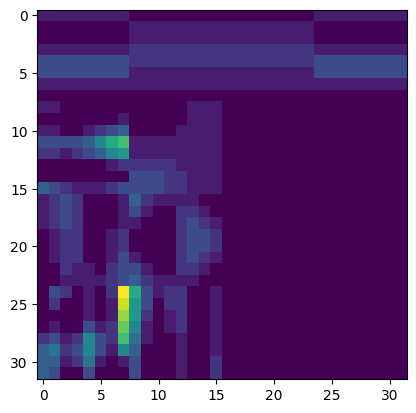

torch.Size([1, 1, 32, 32])
torch.Size([32, 32, 1])


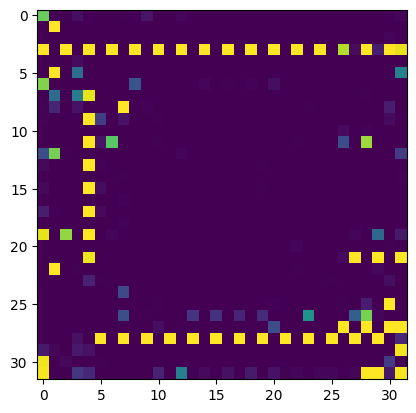

In [30]:
test_spec = Image.open("Data/pop/pop_spec50.jpg")
make_tensor = torchvision.transforms.ToTensor()
test_spec = transform(test_spec)
test_spec = torch.transpose(test_spec, 0, 2)

fig, axs = plt.subplots(1)
axs.imshow(test_spec)
plt.show()


test_spec = torch.transpose(test_spec, 0, 2)
test_spec = torch.unsqueeze(test_spec, 0)
# test_spec = torch.transpose(test_spec, 0, 1)

print(test_spec.shape)
test_spec = generator(test_spec)

test_spec = torch.squeeze(test_spec, 0)
test_spec = torch.transpose(test_spec, 0, 2)

print(test_spec.shape)
fig, axs = plt.subplots(1)
axs.imshow(test_spec.detach())
plt.show()



In [ ]:
print("1")

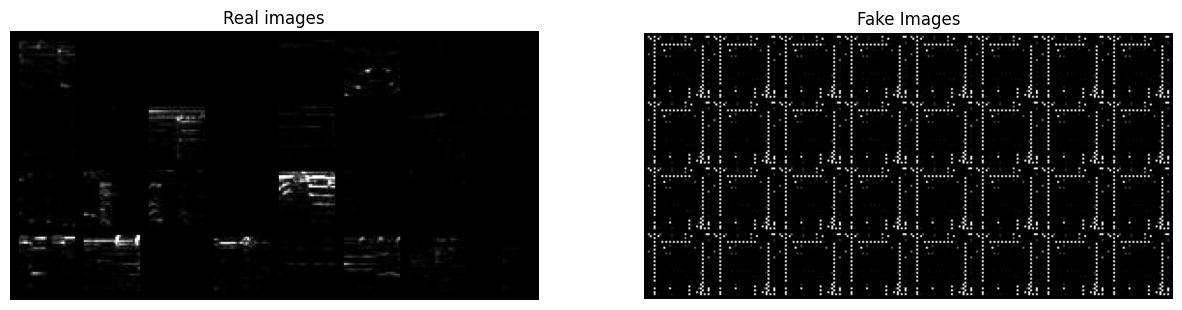

In [35]:
# real_batch = next(iter(dataloader))
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_lists[-1],(1,2,0)))
plt.show()

In [ ]:
print("1")